In [1]:
import dendropy
import numpy as np
from collections import defaultdict
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import csv

In [2]:
north_east = ["Connecticut", "Massachusetts", "New_Hampshire", "Vermont", "Rhode_Island", "New_York"]


In [3]:
def find_change_north_east(nde, sample_dict):
    if nde.taxon:
        if nde.annotations['state'].value in north_east:
            sample_dict["sample"] = (nde.annotations['height'].value, nde.annotations['height_95%_HPD'].value)
            if nde.parent_node.annotations['state'].value not in north_east:
                sample_dict["change_node"] = nde
                sample_dict["change_time"] = (nde.annotations['height'].value, nde.annotations['height_95%_HPD'].value)
                return sample_dict
            else:
                find_change_north_east(nde.parent_node, sample_dict)
                return sample_dict
            
        else:
            return
    else:
        if nde.parent_node.annotations['state'].value not in north_east:
            sample_dict["change_node"] = nde
            sample_dict["change_time"] = (nde.annotations['height'].value, nde.annotations['height_95%_HPD'].value)
            return sample_dict
        else:
            find_change_north_east(nde.parent_node, sample_dict)
            return sample_dict
        
def get_clusters(tree):
    
    path_dict = defaultdict(dict)
    for leaf in tree.leaf_iter():
        path_dict[leaf.taxon.label] = find_change_north_east(leaf, {})
                            
    clusters = defaultdict(list)
    for tip, change in path_dict.items():
        if change:
            if not change['change_node'].taxon:
                clusters[object_to_count[change['change_node']]].append(tip)
            else:
                clusters[change['change_node'].taxon.label].append(tip)

    return clusters, path_dict



In [4]:
def path_to_tip(nde, lst):
    
    for child in nde.child_node_iter():
#         if child.annotations['state'].value in north_east:
        if not child.taxon:
            lst.append(child)
            lst = path_to_tip(child, lst)
        else:
            lst.append(child)
#         else:
#             continue
                           
    return lst

In [6]:
MCC_tree_from_DTA = ""

tree = dendropy.Tree.get(path=MCC_tree_from_DTA, schema="nexus", preserve_underscores=True)

In [7]:
object_dict = {}
object_to_count = {}
count = 0
for nde in tree.preorder_node_iter():
    if nde.taxon:
        object_dict[nde.taxon.label] = nde
    else:
        object_dict[count] = nde
        object_to_count[nde] = count
        count += 1


In [8]:
for nde in tree.preorder_node_iter():
    if not nde.taxon:
        nde.annotations["node_count"] = object_to_count[nde]

tree.write(path="annotated_nodes.tree", schema="nexus")

In [9]:
clusters, path_dict = get_clusters(tree)

/var/folders/pd/bjtp4xt916vfpszlps7rr5_c0000gn/T/ipykernel_92383/2807798569.py:27: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'leaf_iter()' will no longer be supported in future releases; use 'leaf_node_iter()' instead
  for leaf in tree.leaf_iter():


In [14]:
print(len(clusters))

61


## checking if any go out again and into Florida

In [33]:
# do any sequences downstream of the mrca live in florida
first_path_to_tip = {}
for number in clusters.keys():
    mrca = object_dict[number]
    paths = path_to_tip(mrca, [])
    first_path_to_tip[mrca] = paths
        
for nde, path in first_path_to_tip.items():
    for ele in path:
        if ele.annotations['state'].value == "Florida":
            print(object_to_count[ele])
            print(object_to_count[nde])
            
clusters[319] = clusters[318]
del clusters[318]

333
318


## get average branch lens

In [35]:
pre_2014_clusters = {}
post_2014_clusters = {}
for nde, tips in clusters.items():
    dates = []
    pre_count = 0
    for tip in tips:
        dates.append(int(tip.split("|")[1].split("-")[0]))
    for i in dates:
        if i <= 2014:
            pre_count += 1
    
    frac = pre_count/len(dates)
    if frac >= 0.5:
        pre_2014_clusters[nde] = tips   
    else:
        post_2014_clusters[nde] = tips

In [36]:
def get_branch_lens(nde, tmrca, len_list):
    
    if nde.parent_node:
        if nde != tmrca:
            start_branch = float(nde.parent_node.annotations['height'].value)
            end_branch = float(nde.annotations['height'].value)
            length = start_branch - end_branch
            len_list.append(length)
            get_branch_lens(nde.parent_node, tmrca, len_list)
            return len_list
        else:
            return len_list
        
    else:
        print("ERROR: root reached")

In [37]:
branch_lens = defaultdict(list)

for nde, tips in pre_2014_clusters.items():
    tmrca = object_dict[nde]
    if len(tips) >= 3:
        len_list = []
        for tip in tips:
            len_list = get_branch_lens(object_dict[tip], tmrca, len_list)

        branch_lens[nde] = len_list

In [38]:
averages = []
for nde, lens in branch_lens.items():
    averages.append(np.mean(lens))
average_len = (np.mean(averages))
sd = (np.std(averages))
threshold = average_len + (2*sd)

In [39]:
print(average_len)
print(sd)
print(threshold)

1.2801052195263216
1.5238178159442852
4.327740851414892


## using len to chop up intros

In [40]:
def chop_up_clusters(nde, current_mrca, original_mrca):
    
    branch_len = float(nde.parent_node.annotations['height'].value) - float(nde.annotations['height'].value)
    if branch_len < threshold:        
        if nde.parent_node != original_mrca:
            current_mrca = nde.parent_node
            current_mrca = chop_up_clusters(nde.parent_node, current_mrca, original_mrca)
            return current_mrca
        else:
            current_mrca = original_mrca
            return current_mrca 
    else:
        current_mrca = nde
        return current_mrca
    


In [41]:
new_mrca_dict = defaultdict(list)
tip_to_new_mrca = {}
for number, tips in post_2014_clusters.items():
    mrca = object_dict[number]
    if not mrca.taxon:
        for tip in tips:
            tip_obj = object_dict[tip]
            new_mrca = chop_up_clusters(tip_obj, tip_obj, mrca)
            new_mrca_dict[new_mrca].append(tip)
            tip_to_new_mrca[tip] = new_mrca
    else:
        new_mrca_dict[mrca].append(number)
        tip_to_new_mrca[number] = mrca
            
        

In [42]:
pre_mrca_dict = defaultdict(list)
tip_to_new_mrca = {}
for number, tips in pre_2014_clusters.items():
    mrca = object_dict[number]
    if not mrca.taxon:
        for tip in tips:
            tip_obj = object_dict[tip]
            new_mrca = chop_up_clusters(tip_obj, tip_obj, mrca)
            pre_mrca_dict[new_mrca].append(tip)
            tip_to_new_mrca[tip] = new_mrca
    else:
        pre_mrca_dict[mrca].append(number)
        tip_to_new_mrca[number] = mrca

In [43]:
print(len(new_mrca_dict))
print(len(post_2014_clusters))
print(len(pre_2014_clusters))
print(len(pre_mrca_dict))

26
19
42
49


In [44]:
#testing what this does to the pre-2014 clusters average branch len

branch_lens = defaultdict(list)

for nde, tips in pre_mrca_dict.items():
#     tmrca = object_dict[nde]
    tmrca = nde
    if len(tips) > 3:
        len_list = []
        for tip in tips:
            len_list = get_branch_lens(object_dict[tip], tmrca, len_list)

        branch_lens[nde] = len_list
        

averages = []
for nde, lens in branch_lens.items():
    averages.append(np.mean(lens))
average_len = (np.mean(averages))
sd = (np.std(averages))
threshold = average_len + (2*sd)

print(average_len)
print(sd)
print(threshold)

0.47413355157917547
0.166277858917552
0.8066892694142795


## summarising

In [45]:
path_to_tips = {}
for mrca in new_mrca_dict.keys():
    paths = path_to_tip(mrca, [])
    path_to_tips[mrca] = paths
    
for mrca in pre_mrca_dict.keys():
    paths = path_to_tip(mrca, [])
    path_to_tips[mrca] = paths

In [46]:
in_cluster = []
for k,v in path_to_tips.items():
    in_cluster.append(k)
    for i in v:
        in_cluster.append(i)

In [47]:
print(len(in_cluster))

683


## annotate tree with new introductions and writing to file

In [48]:
for nde in tree.preorder_node_iter():
    if nde.parent_node:
        if nde in in_cluster:
            nde.annotations["new_transition"] = "North_East"
        else:
            nde.annotations["new_transition"] = "Other"
    

In [49]:
tree.write(path="new_introductions.tree", schema="nexus")

In [50]:


with open("introduction_times.csv", 'w') as fw:
    fieldnames = ["node_number", "node_height", "tips"]
    writer = csv.DictWriter(fw, fieldnames = fieldnames)
    writer.writeheader()
    
    for mrca, tips in new_mrca_dict.items():
        write_dict = {}
        if not mrca.taxon:
            write_dict["node_number"] = object_to_count[mrca]
        else:
            write_dict["node_number"] = mrca.taxon.label
        write_dict["node_height"] = mrca.annotations['height'].value
        write_dict["tips"] = ";".join([x for x in tips])
        
        writer.writerow(write_dict)
        
    for mrca, tips in pre_mrca_dict.items():
        write_dict = {}
        if not mrca.taxon:
            write_dict["node_number"] = object_to_count[mrca]
        else:
            write_dict["node_number"] = mrca.taxon.label
        write_dict["node_height"] = mrca.annotations['height'].value
        write_dict["tips"] = ";".join([x for x in tips])
        
        writer.writerow(write_dict)

## exploring those intros

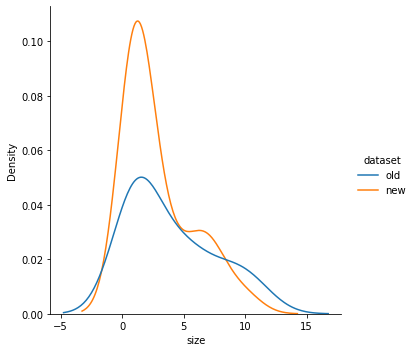

In [51]:
## size
old_sizes = []
new_sizes = []
df_dict = defaultdict(list)

for k,v in post_2014_clusters.items():
    old_sizes.append(len(v))
    df_dict['dataset'].append("old")
    df_dict["size"].append(len(v))

for v in new_mrca_dict.values():
    new_sizes.append(len(v))
    df_dict['dataset'].append("new")
    df_dict["size"].append(len(v))

df = pd.DataFrame(df_dict)

sns_plot = sns.displot(df, x='size', hue="dataset", kind='kde')

plt.show()
    

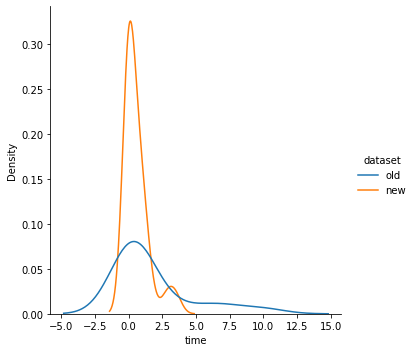

In [52]:
## timings
old_dists = []
df_dict = defaultdict(list)
for nde, tips in post_2014_clusters.items():
    nde = object_dict[nde]
    heights = []
    for tip in tips:
        height = float(object_dict[tip].annotations['height'].value)
        heights.append(height)
        
    earliest = max(heights)
    diff = float(nde.annotations['height'].value) - earliest 
    
    df_dict['dataset'].append("old")
    df_dict["time"].append(diff)
    
for nde, tips in new_mrca_dict.items():
    heights = []
    for tip in tips:
        height = float(object_dict[tip].annotations['height'].value)
        heights.append(height)
        
    earliest = max(heights)
    diff = float(nde.annotations['height'].value) - earliest  
    
    df_dict['dataset'].append("new")
    df_dict["time"].append(diff)
    
df = pd.DataFrame(df_dict)

sns_plot = sns.displot(df, x='time', hue="dataset", kind='kde')


plt.show()